In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
mean_rgb = [0.485,0.456,0.406]
std_rgb = [0.229,0.224,0.225]
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_rgb,std_rgb)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_rgb,std_rgb)
    ])
}

In [5]:
data_dir = '/content/drive/MyDrive/hymenoptera_data'
#Creating a dictionary that contains the information of the images in both of the training and validation dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}
#Creating a dictionary that contains the data loaders
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size = 4,
                                              shuffle = True) for x in ['train','val']}
#Creating a dictionary that contains the size of each datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
#Get the class names
class_names = image_datasets['train'].classes

print('Name of the classes : {}'. format(class_names))
print('There are {} batches in train dataset'. format(len(data_loaders['train'])))
print('There are {} batches in test dataset'. format(len(data_loaders['val'])))
print('There are {} training images'.format(dataset_sizes['train']))
print('There are {} testing images'.format(dataset_sizes['val']))


Name of the classes : ['ants', 'bees']
There are 61 batches in train dataset
There are 38 batches in test dataset
There are 244 training images
There are 152 testing images


In [6]:
#Load the ResNet
model_conv = torchvision.models.resnet18(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s]


In [7]:
#Freeze all the layers in the network
for param in model_conv.parameters():
  param.requires_grad = False

In [9]:
#Get the number of inputs of the last layer
num_features = model_conv.fc.in_features
#Reconstruct the final layer
model_conv.fc = nn.Linear(num_features, 2)

In [10]:
if torch.cuda.is_available():
  model_conv = model_conv.cuda()

In [17]:
#Finetuning the network
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters(),lr = 0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

num_epochs = 25
for epoch in range (num_epochs):
  exp_lr_scheduler.step()
  correct = 0
  for images,labels in data_loaders['train']:
    images = Variable(images)
    labels = Variable(labels)
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    optimizer.zero_grad()
    outputs = model_conv(images)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    _,predicted = torch.max(outputs,1)
    correct += (predicted==labels).sum()

  train_accuracy = 100*correct/dataset_sizes['train']
  print('Epoh: {}/{}, Loss: {}, Train accuracy: {}'.format(epoch+1, num_epochs, loss, train_accuracy))

Epoh: 1/25, Loss: 1.4482793807983398, Train accuracy: 70.08196258544922
Epoh: 2/25, Loss: 0.2074185460805893, Train accuracy: 73.7704849243164
Epoh: 3/25, Loss: 0.6174765825271606, Train accuracy: 80.73770141601562
Epoh: 4/25, Loss: 0.045359838753938675, Train accuracy: 70.08196258544922
Epoh: 5/25, Loss: 0.011751886457204819, Train accuracy: 85.24589538574219
Epoh: 6/25, Loss: 0.11774631589651108, Train accuracy: 83.19671630859375
Epoh: 7/25, Loss: 0.05616322532296181, Train accuracy: 88.52458190917969
Epoh: 8/25, Loss: 0.16416993737220764, Train accuracy: 85.65573120117188
Epoh: 9/25, Loss: 0.015993665903806686, Train accuracy: 88.52458190917969
Epoh: 10/25, Loss: 1.139229655265808, Train accuracy: 83.60655212402344
Epoh: 11/25, Loss: 1.3196946382522583, Train accuracy: 83.19671630859375
Epoh: 12/25, Loss: 0.0635739117860794, Train accuracy: 88.52458190917969
Epoh: 13/25, Loss: 0.035624369978904724, Train accuracy: 84.8360595703125
Epoh: 14/25, Loss: 0.3261759579181671, Train accurac

In [20]:
# Testing the model
model_conv.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images,labels in data_loaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    outputs = model_conv(images)
    _,predicted = torch.max(outputs,1)
    total += labels.size(0)
    correct += (predicted==labels).sum()

  test_accuracy = 100*correct/total
  print('Test accuracy: {}%'.format(test_accuracy))

Test accuracy: 94.07894897460938%


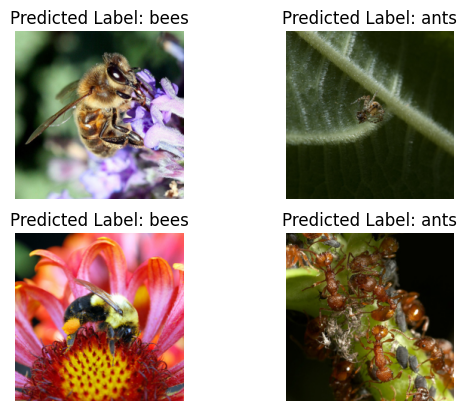

In [21]:
#Visualize some predictions
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
  for images,labels in data_loaders['val']:
    if shown_batch == 1:
      break
    shown_batch +=1
    images = Variable(images)
    labels = Variable(labels)
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    outputs = model_conv(images)
    _,predicted = torch.max(outputs,1)

    for i in range(4):
      index += 1
      ax = plt.subplot(2,2,index)
      ax.axis('off')
      ax.set_title('Predicted Label: {}'.format(class_names[predicted[i]]))
      input_img = images.cpu().data[i]
      inp = input_img.numpy().transpose((1,2,0))
      mean = np.array(mean_rgb)
      std = np.array(std_rgb)
      inp = std*inp + mean
      inp = np.clip(inp,0,1)
      plt.imshow(inp)